<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 50pt; font-weight: bold; color: #B51F1F;">Practical filters for Audio Processing</p>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal

import import_ipynb
from FilterUtils import *

importing Jupyter notebook from FilterUtils.ipynb


In [2]:
plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 14})

In [3]:
DEFAULT_SF = 16000

# The versatile second-order section (aka, the biquad)

<img src="img/biquad.png" alt="Drawing" style="float: right; width: 400px; margin: 0px 30px;"/>

<br>

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}}
$$

## The biquad as a building block

 * if $a_2 = b_2 = 0$ it becomes a first-order section
 * if $a_1 = a_2 = 0$ it becomes an FIR
 * we can factor any transfer function as a cascade of biquads:
 $$
    \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{a_0 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}} = \prod_{k=0}^{\lceil N/2 \rceil} \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}{1 + a_{k,1} z^{-1} + a_{k,2}z^{-2}}
 $$

## The biquad's stability

 * position of poles is a complicated function of filter coefficients
 * coefficients are necessarily quantized
 * poles in higher-order filters difficult to control
 * optimized biquad implementations for different types of precision (fixed point, floating point, etc)

## Biquads as standalone filters

Biquads are quite good on their own! The _cookbook_ that follows provides recipes for
 * lowpass, highpass, bandpass
 * notches and resonators
 * shelves
 * equalizers

# Audio signal processing: the world of log-log

Remember from standard DSP our friend the leaky integrator? 

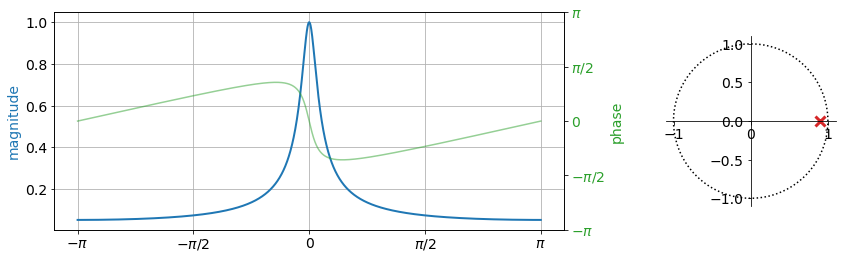

In [4]:
lam = 0.9
filter_props([1 - lam], [1, -lam])

This is how this guy looks like in an audio signal processing environment:

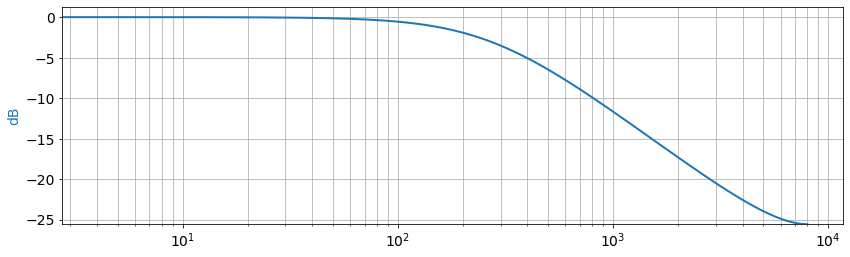

In [5]:
analog_response([1 - lam], [1, -lam], DEFAULT_SF, dB=-50)

NB: these plotting functions are available in the companion notebook ``FilterUtils.ipynb``

## The frequency axis
 
 * audio DSP works within a very specific frequency range: 16 Hz to 20 kHz
 * filter specifications use frequency values in Hz (instead of normalized values over $[-\pi, \pi]$)
 * the frequency axis is logarithmic, because musical intervals are determined by frequency _ratios_ , not differences
 * using $\log_{10}$ splits the frequency axis into **decades**
 
Using real-world frequencies in digital filter design requires knowing the sampling frequency used in the final application: **filter coefficients depend on sampling frequency**

## The magnitude

<img src="img/spl.png" alt="rlc" style="float: right; width: 400px; margin: 0;"/>

 * the human ear has an enormous dynamic range: 130 dB or $1:10^{13}$ 
 * we perceive loudness on a log scale
 * magnitude of frequency response displayed in dB (log scale)

# From analog filters to digital biquads

<img src="img/rlc.png" alt="rlc" style="float: right; width: 250px; margin: 0 10px 10px 30px;"/>

 * RLC filters are well understood and we have "ancient scrolls" we can follow
 * same for active filters
 * canonical biquads are discretized version of analog prototypes

## The analog prototypes

Biquad design task: given a set of specs, find 5 filter coefficients. More difficult than you'd expect. 

On the other hand we do know things like: 
 * second-order Butterworth lowpass: $H(s) = \frac{1}{s^2 + \sqrt{2} s + 1}$
 * second-order resonator: $H(s) = \frac{2\zeta s}{s^2 + 2\zeta s + 1}$
 * etc.

How do we convert these reliable analog designs to discrete time?

## The bilinear transform

 * RLC circuit $\rightarrow$ differential equation 
 * Laplace transform: differential equation $\rightarrow$ transfer function $H(s)$
 * bilinear transform: $H(s)$ $\rightarrow$ $H_d(z)$

### From $s$-plane to $z$-plane
<img src="img/bilinear.png" alt="rlc" style="float: right; width: 300px; margin: 10px 0;"/>
 
$$
    s \leftarrow c \frac{1 - z^{-1}}{1 + z^{-1}} = \Phi_{c}(z)
$$

 * the inside of the unit circle on the $z$-plane is mapped to the left half of the $s$-plane, which preserves stability
 * the unit circle on the $z$-plane is mapped to the imaginary axis of the $s$-plane

### The frequency axis

$$
    H_d(e^{j\omega}) = H(\Phi_{c}(e^{j\omega})) = H(j\,c\tan(\omega/2))
$$

 * $\omega=0 \rightarrow \Omega=0$
 * $\omega=\pi/2 \rightarrow \Omega=c$
 * $\omega=\pi \rightarrow \Omega=\infty$
 
What about this constant $c$ ? 

### Pre-warping

Frequency mapping is $\Omega \leftarrow c\tan(\omega/2)$

Suppose something important needs to happen at $\omega_0$ in the digital filter:

 * we want $H_d(e^{j\omega_0}) = v_0$
 * we design analog prototype so that $H(j) = v_0$
 * we choose $c = 1/\tan(\omega_0/2)$ 
 

**Caution with bandpass** : we have $H_d(e^{j\omega_0}) = H(j) = v_0$ but the shape of the response may be very distorted! 

Example: simple continuous-time frequency response with triangular shape

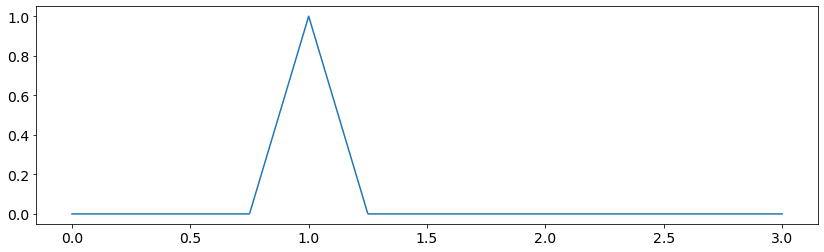

In [101]:
def H(f, scale=1):
    return np.maximum(1 - 4 * np.abs(np.imag(f) - 1) / scale, 0)

f = np.linspace(0, 3, 1000)
plt.plot(f, H(1j * f));

Using the bilinear transform with pre-warping, we can move the equivalent discrete-time frequency response over the $[0, \pi]$ interval.

Note narrow bandwidth at low end and asymmetry at high end

In [105]:
def BL(z, c=1):
    return c * (1 - 1/z) / (1 + 1/z)

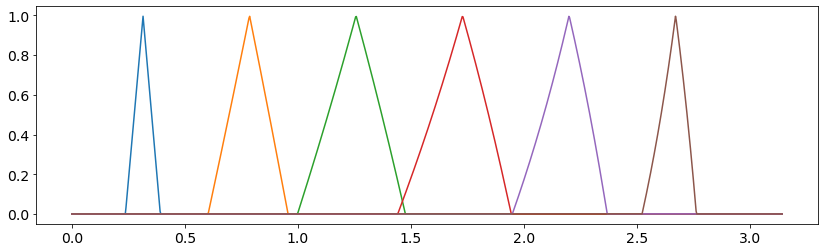

In [116]:
w = np.linspace(0, np.pi, 1000)
center_freqs = np.pi * np.arange(0.1, 0.9, 0.15)

for w0 in center_freqs:
    c = 1 / np.tan(w0 / 2)
    plt.plot(w, H(BL(np.exp(1j * w), c=c)))

We can try to compensate a bit by changing the width of the analog prototype

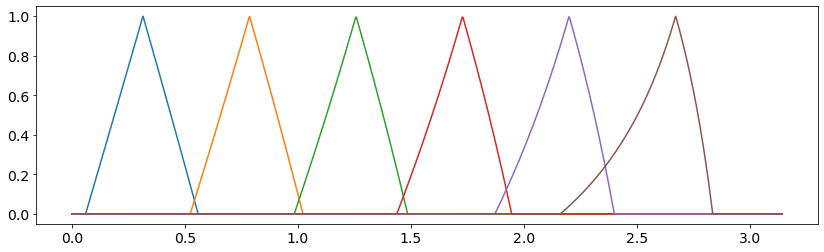

In [117]:
for w0 in center_freqs:
    c = 1 / np.tan(w0 / 2)
    scaling_factor = (c * c + 1) / (2 * c)
    plt.plot(w, H(BL(np.exp(1j * w), c=c), scale=scaling_factor))

**Exercise**: try to formulate a full derivation for the scaling factor

# What about FIRs ?

FIRs are great:
 * you can have linear phase
 * always stable
 * great design algorithm (Parks-McClellan) even for arbitrary responses
 
However:
 * we don't care so much for linear phase in audio
 * they are computationally much more expensive
 * the long impulse response causes significant processing delay: problem in real-time applications

## Audiophiles' myths about FIRs
 
 * they sound "cold"
 * you can hear pre-echos for linear phase FIRs
 * excessive ringing in the impulse response for minimum-phase FIRs
 * ...
 
Honestly, I don't know. Never heard anything disturbing. Major problem remains the delay.

# The cookbook (finally!)

The recipes have been adapted from Robert Bristow-Johnson's famous [cookbook](https://webaudio.github.io/Audio-EQ-Cookbook/audio-eq-cookbook.html). 

Each function returns ``b`` and ``a``, two arrays of three floats each containing the coefficients of the transfer function

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}} \qquad (a_0 = 1)
$$

## Lowpass

Specs:
 1. quality factor $Q$; default is $Q = \sqrt{1/2}$ for a monotonic, maximally flat characteristic (Butterworth)
 1. _corner frequency_ $f_c$ (aka _cutoff_ ); $|H(f_c)| = Q$ (for $Q = \sqrt{1/2}$, attenuation at $f_c$ is $-3$ dB)

In [9]:
def LPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad lowpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 - c) / 2, 1 - c, (1 - c) / 2])
    return b / a[0], a / a[0]

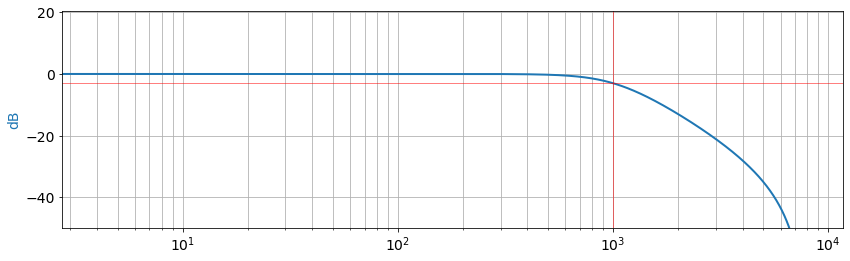

In [10]:
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-50)
plt.axhline(y=-3, linewidth=0.5, color='r')    
plt.axvline(x=CUTOFF, linewidth=0.5, color='r');

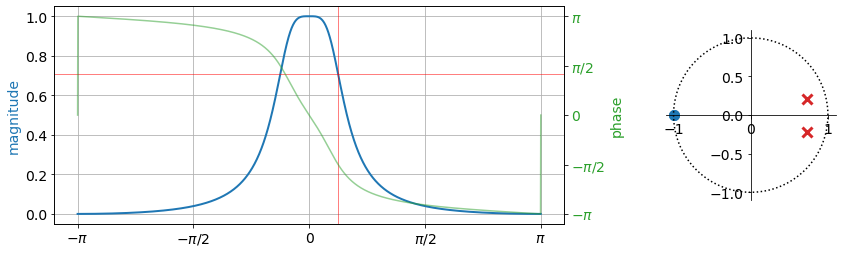

In [11]:
filter_props(b, a)
plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CUTOFF / DEFAULT_SF), linewidth=0.5, color='r');

### Resonance peak

If $Q > 1/\sqrt{2}$, the magnitude response has a **peak** at $f_c$.

In the time domain, this corresponds to a damped oscillatory impulse response.

These $Q$ values become useful when cascading multiple sections, as we will see later.

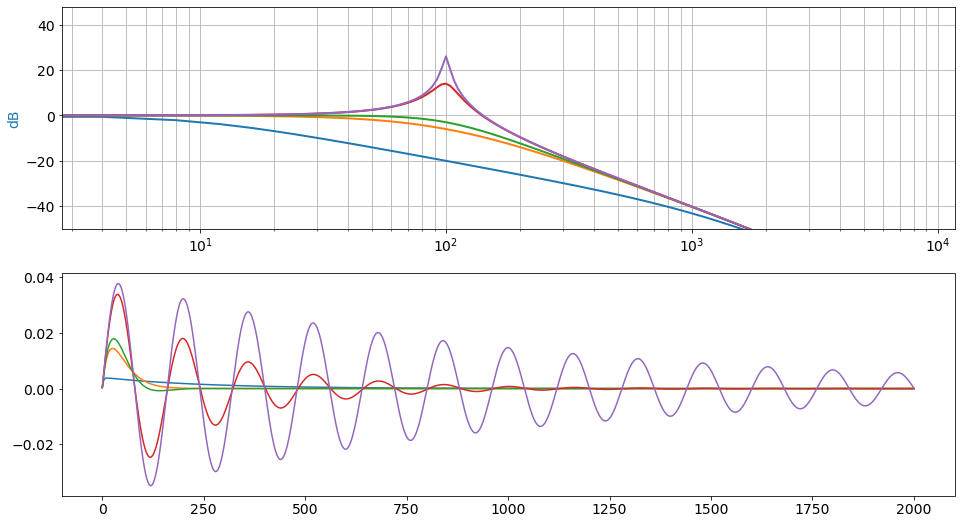

In [12]:
_, (fr, ir) = plt.subplots(2, figsize=(16,9))
CUTOFF = 100
Q = [0.1, 0.5, 1/np.sqrt(2), 5, 20]
for n, q in enumerate(Q):
    b, a = LPF(CUTOFF, DEFAULT_SF, Q=q)
    analog_response(b, a, DEFAULT_SF, dB=-50, axis=fr, color=f'C{n}')
    ir.plot(signal.lfilter(b, a, np.r_[1, np.zeros(2000)]))

## Highpass

A highpass filter is simply the complementary filter to a lowpass, with the same roles for $f_c$ and $Q$.

In [13]:
def HPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad highpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 + c) / 2, -1 - c, (1 + c) / 2])
    return b / a[0], a / a[0]

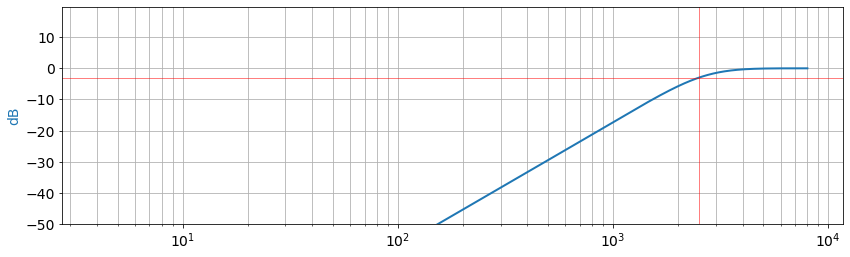

In [14]:
CUTOFF = 2500
b, a = HPF(CUTOFF, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-50)
plt.axhline(y=-3, linewidth=0.5, color='r')    
plt.axvline(x=CUTOFF, linewidth=0.5, color='r');

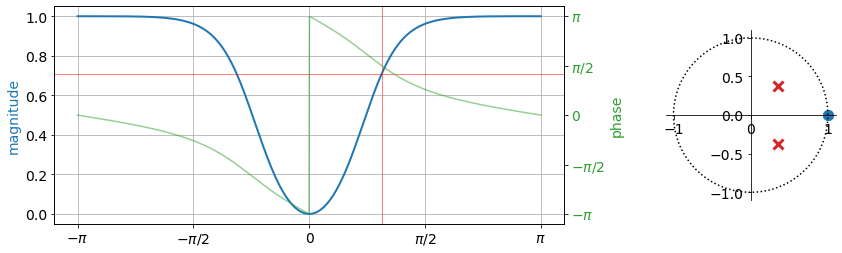

In [15]:
filter_props(b, a)
plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CUTOFF / DEFAULT_SF), linewidth=0.5, color='r');

## Bandpass

Approximately unit gain (0 dB) in the passband. Specs:

 1. center frequency $f_c$
 1. bandwidth $b = (f_+ - f_-)$, frequencies where attenuation reaches $-3$ dB. Passband is almost but not exactly symmetric around $f_c$ (because of bilinear transform)

In [16]:
def BPF(fc, bw, sf):
    """Biquad bandpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([alpha, 0, -alpha])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

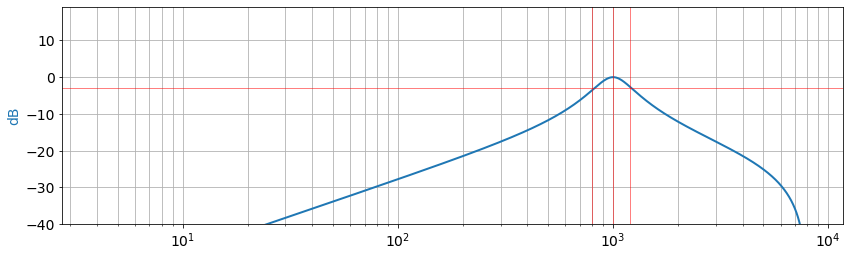

In [17]:
CENTER, BANDWIDTH = 1000, 400
b, a = BPF(CENTER, BANDWIDTH, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-40)
plt.axhline(y=-3, linewidth=0.5, color='r')    
plt.axvline(x=CENTER, linewidth=0.5, color='r')
plt.axvline(x=CENTER - BANDWIDTH / 2, linewidth=0.5, color='r')
plt.axvline(x=CENTER + BANDWIDTH / 2, linewidth=0.5, color='r');

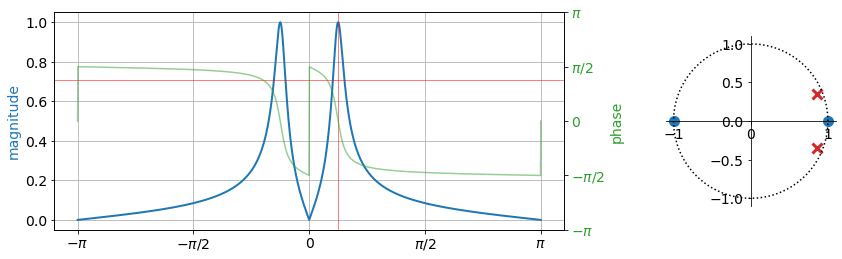

In [18]:
filter_props(b, a)
plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CENTER / DEFAULT_SF), linewidth=0.5, color='r');

## Resonator

When the bandwith is very small, the second order bandpass becomes a constant-gain resonator:

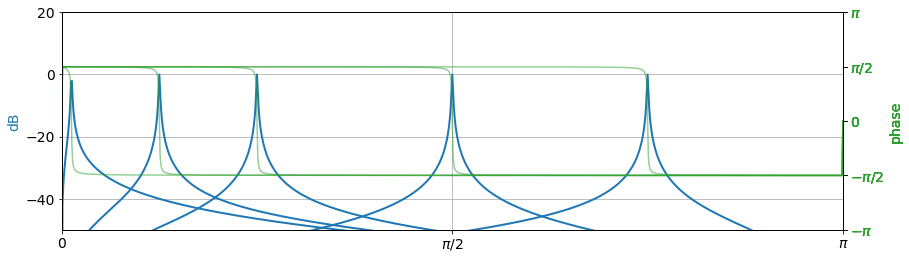

In [19]:
_, ax = plt.subplots()
BANDWIDTH = 10
FC = [100, 1000, 2000, 4000, 6000]
for n, fc in enumerate(FC):
    b, a = BPF(fc, BANDWIDTH, DEFAULT_SF)
    frequency_response(b, a, dB=-50, half=True, axis=ax);

## Notch

Complementary filter to a resonator:
 * infinite attenuation at $f_c$ (zeros on unit circle)
 * very small bandwidth (poles very close to zeros)

In [20]:
def notch(fc, bw, sf):
    """Biquad notch filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1, -2 * c, 1])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

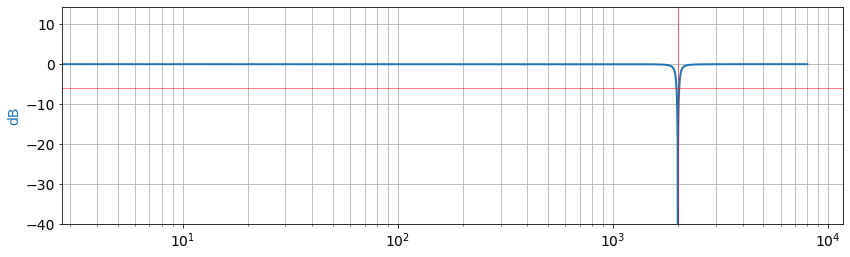

In [21]:
CENTER, BANDWIDTH = 2000, 100
b, a = notch(CENTER, BANDWIDTH, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-40)
plt.axhline(y=-6, linewidth=0.5, color='r')    
plt.axvline(x=CENTER, linewidth=0.5, color='r');

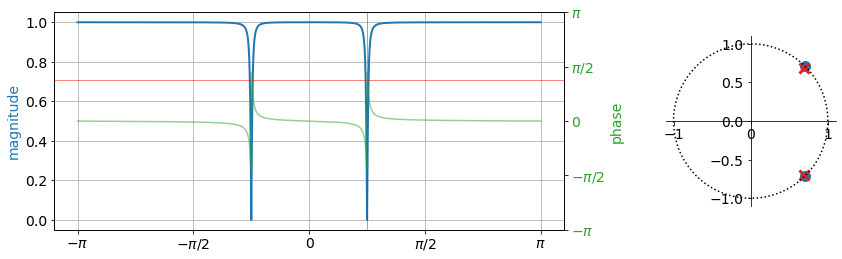

In [22]:
filter_props(b, a)
plt.gcf().get_axes()[0].axhline(y=np.sqrt(0.5), linewidth=0.5, color='r')    
plt.gcf().get_axes()[0].axvline(x=(2 * np.pi * CENTER / DEFAULT_SF), linewidth=0.5, color='r');

## Shelves

Shelving filters are used to amplify either the low or the high end of a signal's spectrum; common in consumer audio appliances, behind the standard "Bass" and "Treble" tone knobs. Specs:

 1.  _shelf gain_ in dB
 1. the midpoint frequency $f_c$, where gain reaches half its value
 1. "quality factor" $Q$, as in lowpass filters

In [23]:
def LSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad low shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  2 * A * ((A - 1) - (A + 1) * c),
                  A * ((A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 -2 * ((A - 1) + (A + 1) * c),
                 (A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

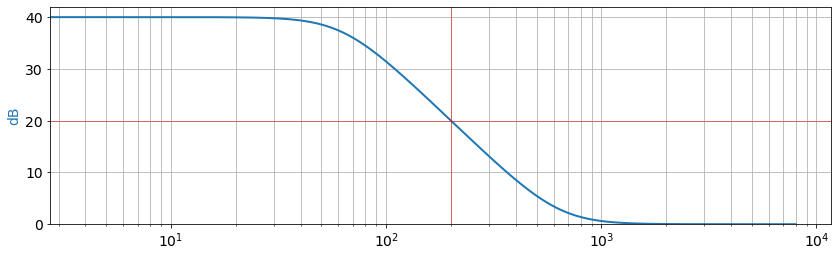

In [24]:
MIDPOINT, GAIN_DB = 200, 40
b, a = LSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-40)
plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
plt.axvline(x=MIDPOINT, linewidth=0.5, color='r');

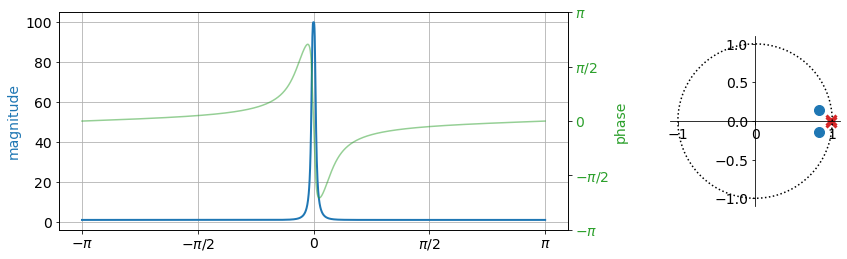

In [25]:
filter_props(b, a);

In [26]:
def HSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad high shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  -2 * A * ((A - 1) + (A + 1) * c),
                  A * ((A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 2 * ((A - 1) - (A + 1) * c),
                 (A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

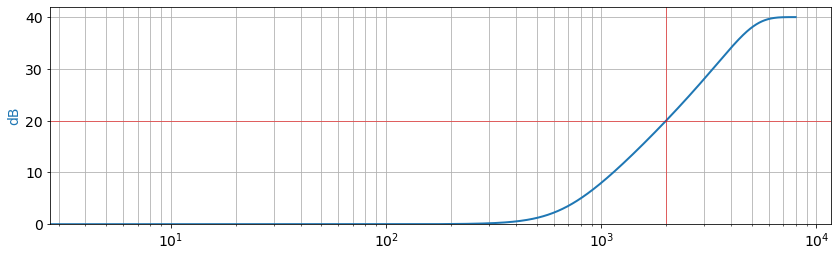

In [27]:
MIDPOINT, GAIN_DB = 2000, 40
b, a = HSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-40)
plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
plt.axvline(x=MIDPOINT, linewidth=0.5, color='r');

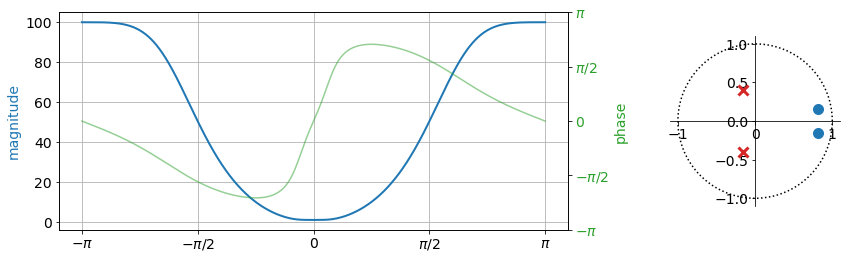

In [28]:
filter_props(b, a);

## Peaking EQ

Fundamental ingrediend in multiband equalization. Provides an arbitrary boost or attenuation for a given frequency band centered around a peak freqency and flattens to unit gain elsewhere. Specs:

 1. desired gain in dB (can be negative)
 1. peak frequency $f_c$, where gain is attained
 1. bandwidth: interval around $f_c$ where gain is more than half of final gain (in dB); again, bandwdidth is not perfectly symmetrical around $f_c$ 

In [29]:
def PEQ(fc, bw, gain, sf):
    """Biquad bandpass filter """
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1 + alpha * A, -2 * c, 1 - alpha * A])
    a = np.array([1 + alpha / A, -2 * c, 1 - alpha / A])
    return b / a[0], a / a[0]

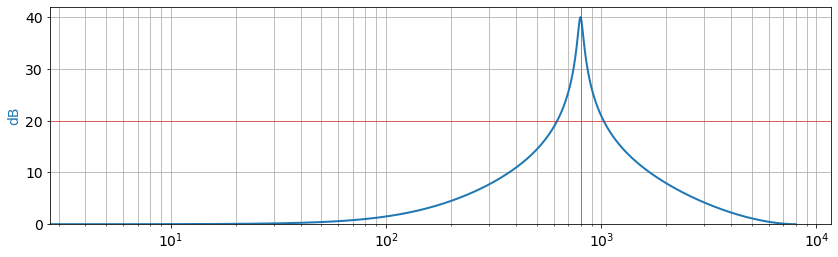

In [30]:
CENTER, BW, GAIN_DB = 800, 400, 40
b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-40)
plt.axhline(y=GAIN_DB / 2, linewidth=0.5, color='r')    
plt.axvline(x=CENTER, linewidth=0.5, color='r');

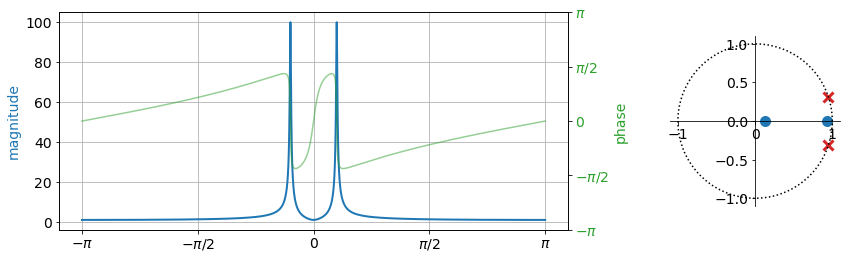

In [31]:
filter_props(b, a);

Note that peaking EQ filters with opposite gains are perfectly complementary: 

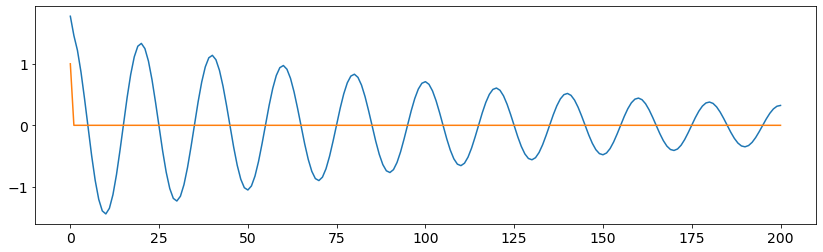

In [32]:
CENTER, BW, GAIN_DB = 800, 400, 40
b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
y = signal.lfilter(b, a, np.r_[1, np.zeros(200)])
plt.plot(y)
b, a = PEQ(CENTER, BW, -GAIN_DB, DEFAULT_SF)
y = signal.lfilter(b, a, y)
plt.plot(y);

# Cascades of biquads

Often the performance of a second-order filter is not enough.

 * higher-order filters can be decomposed into second-order stages
 * "canonical" biquads can be repeated to improve or change overall performance

Applications:
 * increase rejection in stopband
 * combine shelves to provide tone control
 * design multiband equalizers

## Factorization of higher-order filters

Reliable algorithms exist to design high-order filters (Butterworth, Chebyshev, elliptic, etc.)

 * coefficient quantization causes pole drift
 * implementation are more robust in factored form

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{a_0 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}} = \prod_{k=0}^{N/2} \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}{1 + a_{k,1} z^{-1} + a_{k,2}z^{-2}}
$$

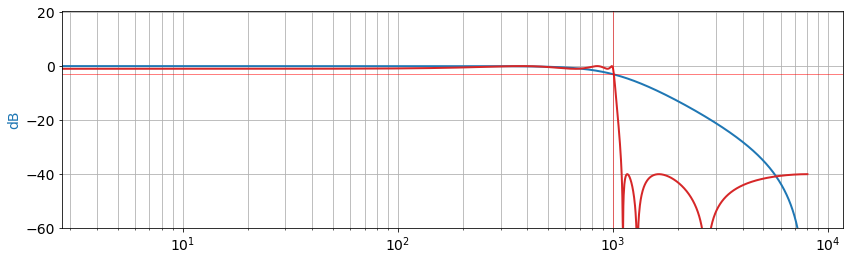

In [33]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C0')
eb, ea = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF)
analog_response(eb, ea, DEFAULT_SF, dB=-60, axis=ax, color=f'C3')
plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
plt.axhline(y=-3, linewidth=0.5, color='r');     

Let's look at the individual second-order sections:

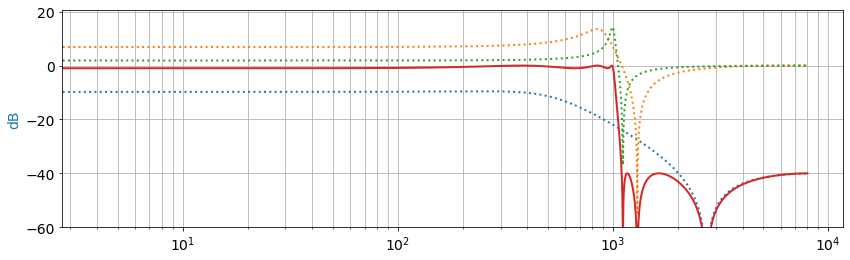

In [34]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
# this returns an array of second-order filter coefficients. Each row corresponds to a section, 
#  with the first three columns providing the numerator coefficients and the last three providing the denominator
soe = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF, output='sos')
cb, ca = [1], [1]
for n in range(0, 3):
    b, a = soe[n][0:3], soe[n][3:6]
    analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}:')
    cb = np.polymul(b, cb)
    ca = np.polymul(a, ca)
analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C3')

## Cascading lowpass and highpass biquads

 * biquad's transfer function $H(z)$
 * cascade $N$ times
 * overall transfer function $H_c(z) = H^N(z)$
 * magnitude response in dB multiplied by $N$

Example: cascade of five second-order Butterworth lowpass

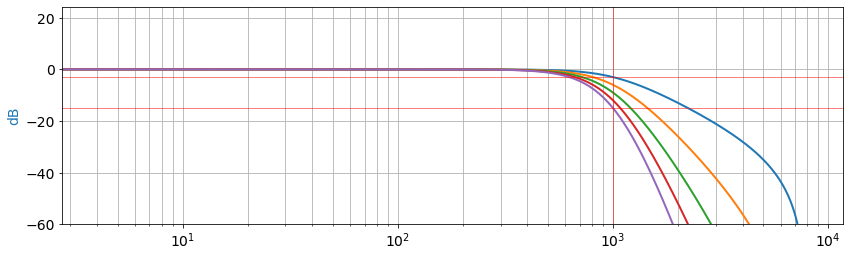

In [35]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
cb, ca = b, a
for n in range(0, 5):
    analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}')
    ca = np.polymul(a, ca)
    cb = np.polymul(b, cb)
plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
plt.axhline(y=-3, linewidth=0.5, color='r')    
plt.axhline(y=-15, linewidth=0.5, color='r');    

Good things:
  * still monotonic
  * steeper transition to stopband

Problems:
  * cutoff frequency moves
  * bandwidth decreases
  
Can we (easily) obtain a cascade with controlled $f_c$ and Butterworth characteristic?
  * we can always use Python and get a high-order filtered in factored form
  * but there's a neat alternative way...

### Poles of a Butterworth filter

$H_N(s)$: transfer function of an order-$N$ Butterworth lowpass

 * the $N$ complex-conjugate poles are equally spaced along a circular contour centered on the origin of the $s$-plane
 * the angle between poles is equal to $\pi/N$
 
Pole angles in the upper $s$-plane: 

$$
    \theta_n = \frac{\pi}{2N} + n\frac{\pi}{N} = \frac{(2n+1)\pi}{2N}, \qquad n = 0, \ldots, N/2
$$

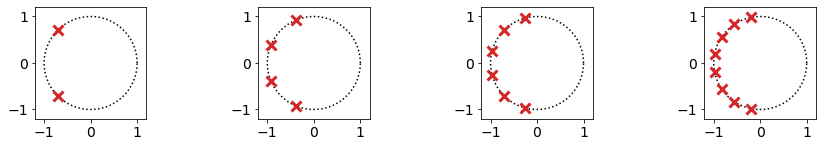

In [36]:
fig, sp = plt.subplots(1, 4, gridspec_kw={'wspace': 1})
for n in range(0, 4):
    sp[n].plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'k:')
    p = np.roots(signal.butter(2 * (n + 1), 1, analog=True)[1])
    sp[n].plot(p.real, p.imag, 'C3x', ms=10, markeredgewidth=3.0)
    sp[n].axis('square')
    sp[n].set_xlim(-1.2, 1.2)        
    sp[n].set_ylim(-1.2, 1.2);

### Poles of an analog second-order lowpass

  * one pair of complex-conjugate poles at $\rho e^{\pm \theta}$
  * fundamental relationship:
    $$ 1/Q = 2\cos \theta $$
  
Solution: simply choose $Q_n = 1/(2\cos \theta_n)$ for stage number $n$ in the cascade!

Example: five lowpass sections (i.e. a  10th-order filter)

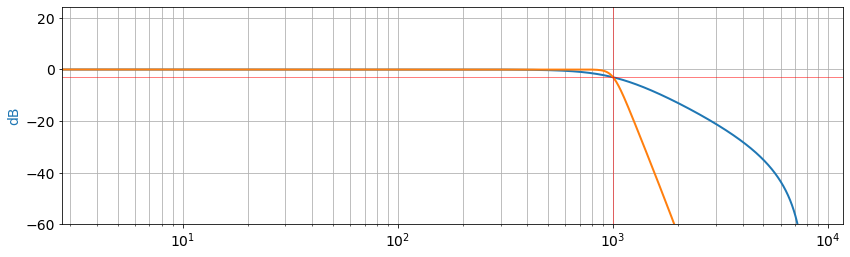

In [37]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color='C0')
cb, ca, sections = [1], [1], 5
for n in range(0, sections):
    iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
    b, a = LPF(CUTOFF, DEFAULT_SF, Q=1/iq)
    ca = np.polymul(a, ca)
    cb = np.polymul(b, cb)
analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1')
plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
plt.axhline(y=-3, linewidth=0.5, color='r');    

The resulting digital filter has its poles arranged on a circular contour centered in $z=1$ if the cutoff frequency is less than $\pi/2$ and centered on $z=-1$ otherwise. 

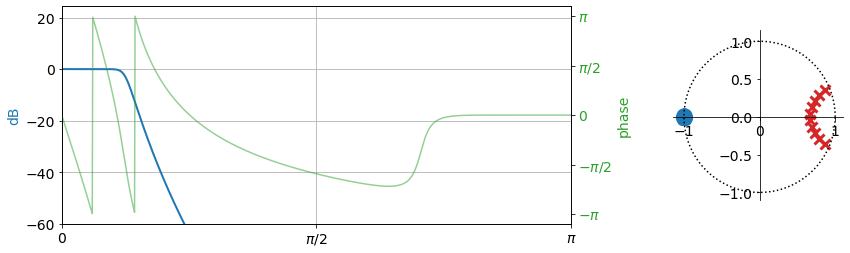

In [38]:
filter_props(cb, ca, DEFAULT_SF, dB=-60);

Individual magnitude responses of the five sections. Some $Q_n$ values lead to peaks!

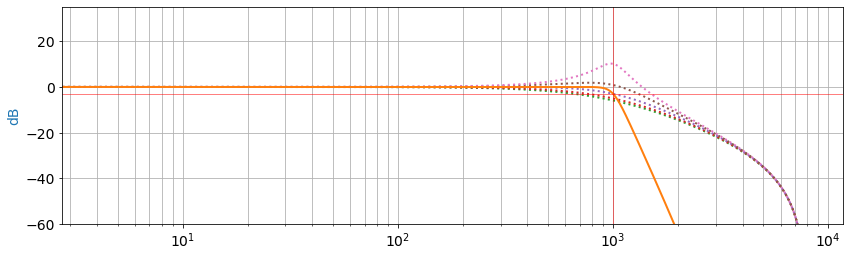

In [39]:
_, ax = plt.subplots()
CUTOFF = 1000
cb, ca, sections = [1], [1], 5
for n in range(0, sections):
    iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
    b, a = LPF(CUTOFF, DEFAULT_SF, Q=1/iq)
    analog_response(b, a, DEFAULT_SF, dB=-0, axis=ax, color=f'C{n+2}:')
    ca = np.polymul(a, ca)
    cb = np.polymul(b, cb)
analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1')
plt.axvline(x=CUTOFF, linewidth=0.5, color='r')    
plt.axhline(y=-3, linewidth=0.5, color='r');    

## Combining shelving filters

Shelving filters may be combined to create filters to boost a particular frequency range

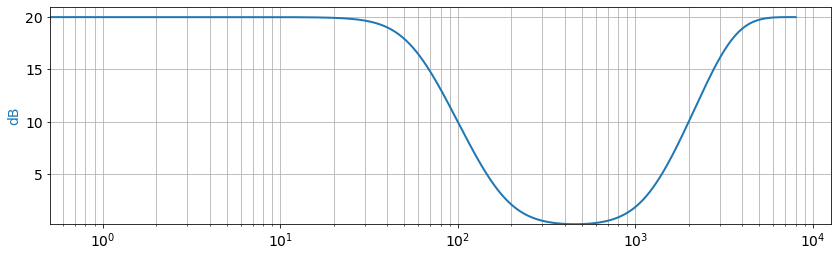

In [40]:
cb, ca = LSH(100, 20, DEFAULT_SF)    
b, a = HSH(2000, 20, DEFAULT_SF)
cb = np.polymul(b, cb) 
ca = np.polymul(a, ca)
analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

Note that amplitudes sum up on a log scale:

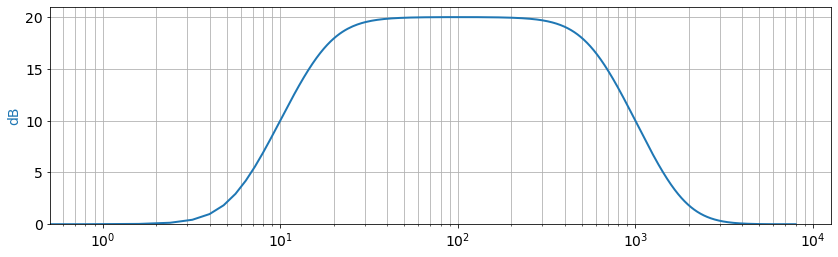

In [41]:
GAIN = 20
cb, ca = LSH(1000, GAIN, DEFAULT_SF)    
b, a = HSH(10, GAIN, DEFAULT_SF)
cb = np.polymul(b, cb) 
ca = np.polymul(a, ca)
# rescale response to have unit gain at band edges
cb *= 10 ** (-GAIN / 20)
analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

## Parametric equalization

Peaking equalizers with distinct bandwidths can be cascaded to obtain an arbitrary equalization curve for the entire range of input frequencies; indeed, this is the technique behind so-called _parametric equalizers_ where a bank of logarithmically spaced peaking eq's with independent gain controls allow the user to easily define a global equalization response.

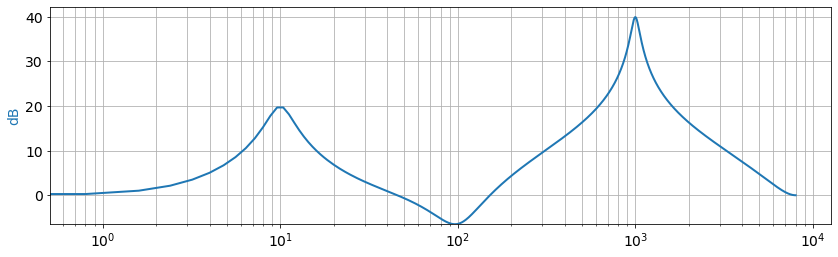

In [42]:
cb, ca = np.ones(1), np.ones(1)
for n, g in enumerate([20, -10, 40]):
    b, a = PEQ(10 ** (n+1), 10 ** (n + 1), g, DEFAULT_SF)
    cb = np.polymul(b, cb)
    ca = np.polymul(a, ca)
analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

# Examples